# A second hand BMW i3 car: which one has the lowest price loss with mileage/age?

In this notebook we will analyse a bunch of BMW i3 second hand cars. A custome asked us the following question: "I would like to buy a BMW i3 second hand car. If I donÄt like it, I would like to re-sell it after one year and lose as less money as possible. Which one, among the available second hand cars, have the lowest value variation with time/mileage?".

At first sight, it seems an odd question. We are going to show that cars loose their value at different rate with time and mileage, and that there is a range of price-mileage to pick the optimal car.

## Data cleaning and EDA

Here we clean up the data ad perform the first exploratory data analysis.

In [54]:
import sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

In [55]:
df = pd.read_csv('data/AS24_BMWi3.csv', index_col=0)

In [56]:
df.head()

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,seller_company_name,seller_CAP,seller_city,price
0,BMW i3,Garanzia batterie e motore 12 mesi,['BMW i3'],109954.0,08/2013,75 kW (102 CV),Usato,3.0,Automatico,Elettrica,Brokar di Riccardo Gioè,20085,Locate di Triulzi MI,12900
1,BMW i3,I3 ELETTRICA PELLE LED NAVIGATORE BLUETOOTH,"['Fari full-LED, Bluetooth, Airbag testa, Fari...",59000.0,10/2014,75 kW (102 CV),Usato,NaN,Automatico,Elettrica,Autobaselli Srl,25027,Quinzano d'Oglio - Brescia - Bs,14900
2,BMW i3,60 Ah (Range Extender),"['Start/Stop Automatico, Volante in pelle, Chi...",68000.0,10/2014,75 kW (102 CV),Usato,NaN,Automatico,Elettrica,BONERA SPA,25135,Brescia,15200
3,BMW i3,i3 *KM 21.000,"['Cerchi in lega, Sistema di navigazione']",21215.0,06/2015,75 kW (102 CV),Usato,NaN,Automatico,Elettrica,Bc Car srl,72023,Mesagne BR,15800
4,BMW i3,NaN,"[""Vetri oscurati, Sistema di chiamata d'emerge...",76000.0,05/2015,125 kW (170 CV),Usato,NaN,Manuale,Elettrica,GV@Auto Srls,40068,San Lazzaro di Savena - Bo,16900


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   model                262 non-null    object 
 1   version              252 non-null    object 
 2   equipments           16 non-null     object 
 3   mileage              222 non-null    float64
 4   mmyy                 262 non-null    object 
 5   power                262 non-null    object 
 6   use_type             262 non-null    object 
 7   n_owners             98 non-null     float64
 8   gear                 262 non-null    object 
 9   fuel_type            262 non-null    object 
 10  seller_company_name  262 non-null    object 
 11  seller_CAP           262 non-null    int64  
 12  seller_city          262 non-null    object 
 13  price                262 non-null    int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 30.7+ KB


In [58]:
#all the cars having null mileage are new
df[df.mileage.isna()]['mmyy'].unique()
#set mileage = 0
df.loc[df.mileage.isna(),'mileage'] = 0

In [59]:
#power
df.power.value_counts()

75 kW (102 CV)     161
125 kW (170 CV)     76
135 kW (184 CV)     24
1 kW (1 CV)          1
Name: power, dtype: int64

One has 1kW, which must be wrong

In [60]:
df['kW'] = df['power'].apply(lambda x: int(x.split()[0]))
df[df.kW==1]

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,seller_company_name,seller_CAP,seller_city,price,kW
194,BMW i3,(I01) 120 Ah,NaN,119.0,08/2019,1 kW (1 CV),KM0,NaN,Automatico,Elettrica,Paradiso Srl,88046,Lamezia Terme - Catanzaro - Cz,35900,1


In [61]:
#no info found to guess the right value. let's assume it has the more frequent power (75 kW)
df.loc[194, 'kW'] = 75

In [62]:
#fuel type columns
df.fuel_type.value_counts()

Elettrica            240
Elettrica/Benzina     21
Benzina                1
Name: fuel_type, dtype: int64

'Elettrica/Benzina' (Electric/Petrol in English) means it has an extender range engine. The car that has 'Benzina' only must be a mistake, Because none of these cars run with petrol only. We will neglect this variable for our analysis.


In [63]:
df.use_type.unique()

array(['Usato', 'Nuovo', 'Dimostrativo', 'Aziendale', 'KM0'], dtype=object)

'use_type' is also not interesting for our analysis.

In [64]:
#all these cars have automatic gear
df.gear.value_counts()

Automatico            233
- (Tipo di cambio)     26
Manuale                 3
Name: gear, dtype: int64

The type of gear is also not importat for us.

In [65]:
df[df.mmyy == '- (Anno)'].use_type.unique()

array(['Nuovo'], dtype=object)

We see there are cars with no "mmyy" information. However, all these cars are new ('nuovo' in italian). Therefore we can set the date to 11/2021 for these cars.

In [66]:
df.loc[df.mmyy == '- (Anno)', 'mmyy'] = '11/2021'

#transform to datetime
df['mmyy'] = df['mmyy'].apply(pd.to_datetime)
df = df.sort_values(by=['mmyy'], ascending=True)

In [67]:
now = pd.to_datetime('11/2021')

In [68]:
# introduce the 'age' value
df['age']  = (now - df.mmyy) / np.timedelta64(1, 'Y')

<IPython.core.display.Javascript object>


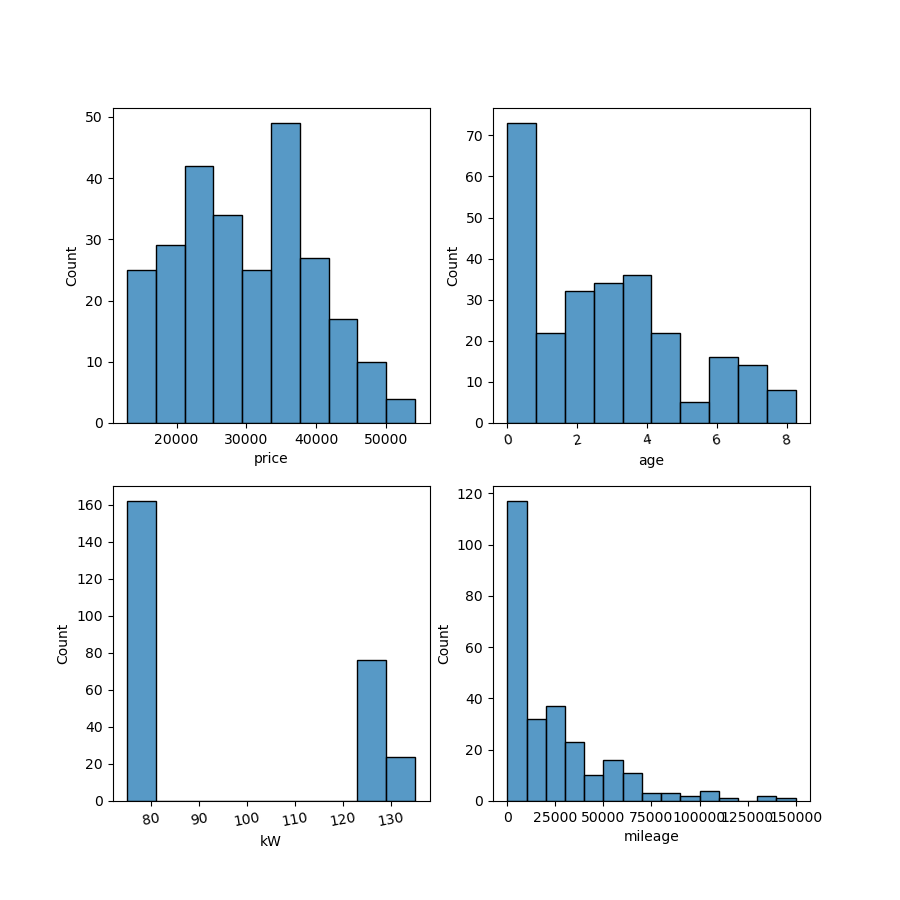

In [71]:
f, axis = plt.subplots(figsize=(9, 9), nrows=2, ncols=2, sharey=False, gridspec_kw={'hspace':0.2, 'wspace':0.2})
ax = axis.flatten()
for i,var in enumerate(['price', 'age', 'kW','mileage']):
    g = sns.histplot(x=var, data=df, ax=ax[i])
    if i in [1,2]:
        ax[i].tick_params(axis='x', rotation=10)
f.savefig('figures/BMWhisto.pdf')

<IPython.core.display.Javascript object>


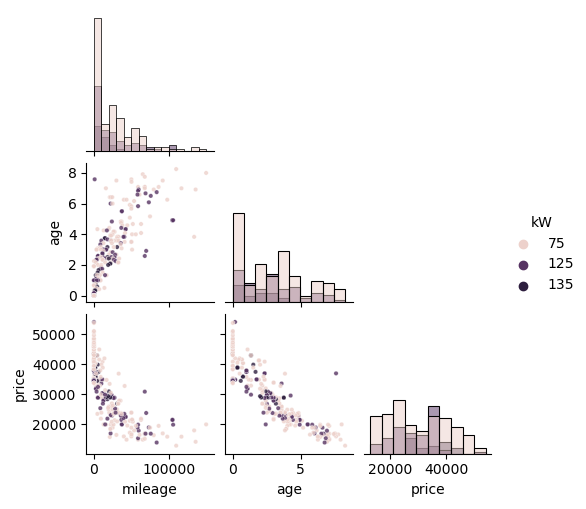

In [70]:
feat = ['mileage','kW','age','price']
g = sns.pairplot(df[feat], hue="kW", height=1.7, diag_kind="hist", corner=True, plot_kws={"s": 10, 'alpha':0.8})
fig = g.fig
fig.savefig('figures/BMWpairplot.pdf')

In [75]:
#there are few outliers
bool_to_drop1 = (df.mileage > 65000) & (df.kW > 100) & (df.price>19500)
bool_to_drop2 = (df.price > 30000) & (df.age > 6.8)
idx_to_drop = df.index[(bool_to_drop1 | bool_to_drop2)]
df.drop(index=idx_to_drop, inplace=True)

In [76]:
idx_to_drop

Int64Index([200, 68, 67, 55, 89, 144], dtype='int64')

## Variation of the price with mileage
Here we compute the first derivative of price w.r.t mileage, which is the main variable we decided to consider. (The other one is 'age', but we have to consider that an old car with small mileage is still in good condition, so age is not so important).

We compute here an approximate first derivative by computing the median of the price in different mileage bins, then the 'derivative' will be computed as the difference in mileage between the bins. Although this is an approximation, it allows us to answer our final question. 

In [77]:
bins = np.array([0, 100, 20000, 40000, 60000, 80000, 180000])
inds = np.digitize(df.mileage, bins)
list_n_bins = np.unique(inds)
list_median = []
for i in list_n_bins:
    boole = (inds==i)
    list_median.append(df.price[boole].median())

list_median.append(list_median[-1])
array_median = np.array(list_median)

<IPython.core.display.Javascript object>


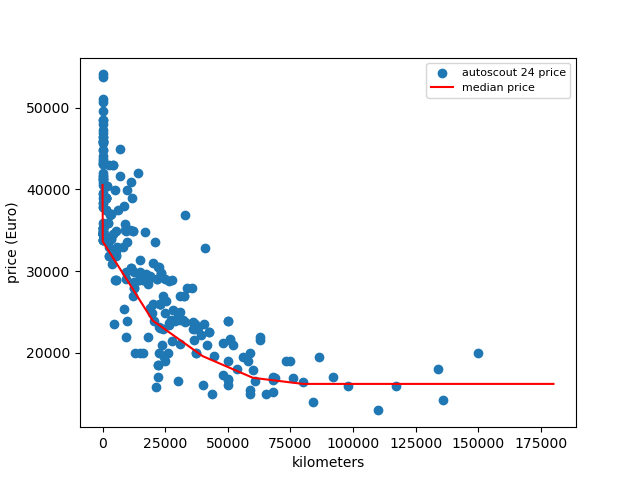

In [78]:
fig, ax = plt.subplots()
price = plt.scatter(df.mileage, df.price)
median_price = plt.plot(bins, array_median, c='red')
ax.set_ylabel('price (Euro)')
ax.set_xlabel('kilometers')
plt.legend((price, median_price[0]),
           ('autoscout 24 price', 'median price'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=8)
fig.savefig('figures/BMW_price_d1.pdf')

In [79]:
#compute derivative
d_price_mileage = np.diff(list_median)/np.diff(bins)

In [80]:
#put the derivative into the dataframe
df['inds'] = inds - 1 #-1 because inds goes from 1 to 6. We want it from 0 to 5
df['price_d1'] = df.inds.apply(lambda x: d_price_mileage[x])

We compute now a "figure of merit", i.e. a linear function that rank the cars as a function of mileage, price, and price variation with mileage. The figure of merit is high when price is low, mileage is low and price variation is low. We use this function to get the "best" cars, i.e. the ones that satisfied our conditions best.

In [81]:
df['fig_of_merit'] = (1. - df.mileage/df.mileage.max()) + (1. - df.price/df.price.max()) + (1. - np.abs(df.price_d1)/np.abs(df.price_d1).max())

<IPython.core.display.Javascript object>


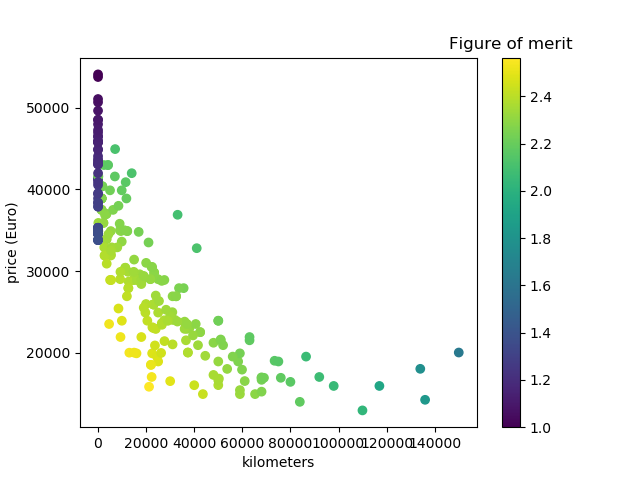

In [82]:
fig, ax = plt.subplots()
plt.scatter(df.mileage, df.price, c=df.fig_of_merit, cmap='viridis')
ax.set_ylabel('price (Euro)')
ax.set_xlabel('kilometers')
cb = plt.colorbar()
cb.ax.set_title('Figure of merit')
fig.savefig('figures/BMW_prediction.pdf')

From the figure above we see that the best cars lie on the low left corner, i.e. for cars with low price and low mileage (km).

## Results
We list here the first 5 cars that fit our requirements best

In [31]:
df[['model','version','mileage','power','mmyy','price','seller_company_name','seller_city','seller_CAP','fig_of_merit']].sort_values(by='fig_of_merit', ascending=False).head(5)

,model,version,mileage,power,mmyy,price,seller_company_name,seller_city,seller_CAP,fig_of_merit
3,BMW i3,i3 *KM 21.000,21215.0,75 kW (102 CV),2015-06-01,15800,Bc Car srl,Mesagne BR,72023,2.563471
8,BMW i3,94Ah,13010.0,75 kW (102 CV),2017-08-01,19980,Okay Cars Srl,Quattro Castella - Reggio Emilia - Re,42020,2.537077
39,BMW i3,FULL ELECTRIC 170CV IVA 22% DEDUCIBILE COMPRESA,22300.0,125 kW (170 CV),2015-11-01,17000,Autoecommerce Srl,San Giovanni in Persiceto - Bologna - Bo,40017,2.534065
86,BMW i3,94 Ah,4600.0,75 kW (102 CV),2017-07-01,23500,Extramotors - Gruppo Maccianti srl,Follonica - Grosseto - Gr,58022,2.528103
12,BMW i3,i3,9350.0,75 kW (102 CV),2018-11-01,21900,Tuacar srl,Moncalieri -To,10024,2.526000
